# Exploratory Data Analysis

This notebook is a non-exhaustive guide to quickly look through data and get a sense of tasks and priorities in a CV project.

Other tasks may also be added based on requirements.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

## 1. Metadata EDA

Supervised CV tasks typically begin with either a meta data csv file or a data structured in folders given their classification names. In both cases, one needs to understand the distribution of the data and whether there is a need to futher subset the dataset according to the task at hand.

Meta data analysis can be categorized into
1. Underlying distribution of data
2. Image type, quality, formats
3. Other information

In [21]:
meta_df = pd.read_csv('./HAM10000_metadata.csv')
print(f"length of dataframe: {meta_df.shape[0]}; columns in dataframe {meta_df.shape[1]}")
print("------")
print("List of columns")
[print(x) for x in meta_df.columns]
print("------")
meta_df.info()

length of dataframe: 10015; columns in dataframe 7
------
List of columns
lesion_id
image_id
dx
dx_type
age
sex
localization
------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
# mapping the types of tumors in their scientific name
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

meta_df['dx'] = meta_df.dx.map(lesion_type_dict)

### 1.1 Underlying distribution of data

1. Missing data
2. Number of images within each class
3. Profile by age

#### 1.1.1 Missing data

Find the number of missing data, there are some missing data by age.

Hence, we will need to consider if age there is a need to segment the images by age

In [25]:
meta_df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

### 1.1.2 Number of images within each class

From here we can see that the number of melanocytic nevi is rather high while the cases of dermatofibroma and vascular lesions are quite low. 

Hence, we might want to think about stratifying the dataset before feeding it to the model to ensure that the model gets a chance to train and validate on all types of data.

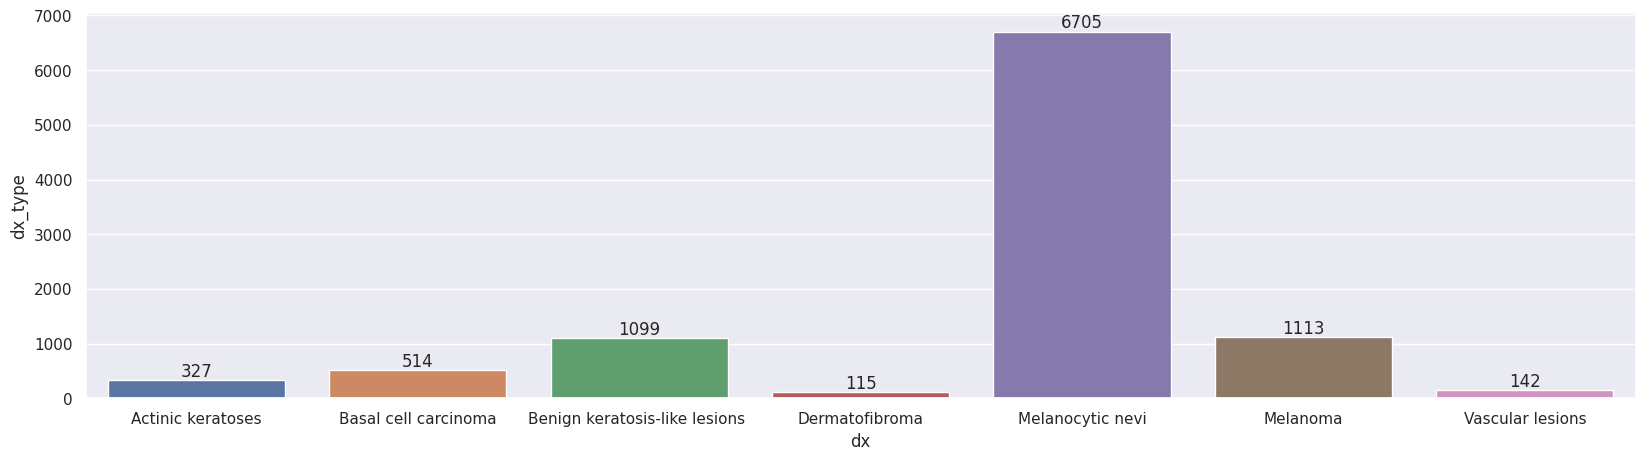

In [23]:
dx_df = meta_df.groupby('dx').count().reset_index()

ax = sns.set_theme(rc={'figure.figsize':(20,5)})
ax = sns.barplot(dx_df, x="dx", y="dx_type")
ax.bar_label(ax.containers[0])
plt.show()

### 1.1.3 Profile of ages

average age 52; max age 85; min age 0


<AxesSubplot: xlabel='age', ylabel='sex'>

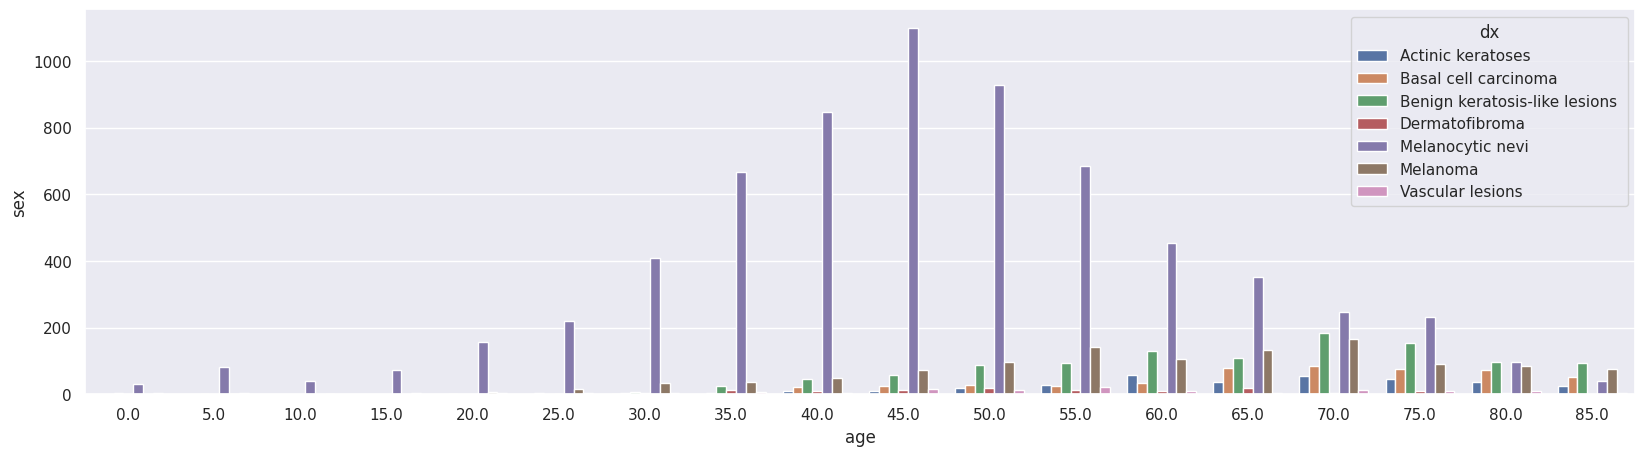

In [24]:
age_df = meta_df.groupby(["dx",'age']).count().reset_index()
age_df
print(f"average age {meta_df.age.mean():.0f}; max age {meta_df.age.max():.0f}; min age {meta_df.age.min():.0f}")
sns.barplot(data=age_df, x='age', y="sex", hue="dx")

In [26]:
meta_df.dx_type.unique()

array(['histo', 'consensus', 'confocal', 'follow_up'], dtype=object)

In [27]:
def map_unknown(x):
    if x =="unknown":
        return np.nan
    else:
        return x

meta_df['sex'] = meta_df.sex.apply(lambda x: map_unknown(x))
meta_df['localization'] = meta_df.localization.apply(lambda x: map_unknown(x))

In [29]:
meta_df.loc[(meta_df.age.isna()) | (meta_df.sex.isna())]
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign keratosis-like lesions,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign keratosis-like lesions,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign keratosis-like lesions,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign keratosis-like lesions,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign keratosis-like lesions,histo,75.0,male,ear


In [30]:
meta_df.loc[meta_df.sex.isna()].shape

(57, 7)

### 2. Image type quality formats

Walk through the dataset and pull out 
1. Filepath
2. Colour mode (RGB, CMYK, RGBA, etc)
3. Size (height and width)
4. Format (JPEG, PNG, etc) 

In [31]:
from PIL import Image
import cv2
import random

In [36]:
def make_dataframe(path):
    filepath, img_mode=[], []
    img_height, img_width=[], []
    img_format= []
    errorpath=[]
    for root, _, files in os.walk(path):
        for f in files:
            file_path = os.path.join(root, f)
            try:
                img = Image.open(file_path)
                filepath.append(file_path)
                img_mode.append(img.mode)
                img_height.append(img.height)
                img_width.append(img.width)
                img_format.append(img.format)

            except:
                errorpath.append(file_path)

        df = pd.DataFrame.from_dict({
            "filepath":filepath, 
            "mode":img_mode, 
            "height": img_height,
            "width": img_width,
            "format": img_format})

        df["directory"] = df["filepath"].apply(lambda x: x.split('/')[-2])
        df["file_name"] = df["filepath"].apply(lambda x: x.split('/')[-1].split('.')[0])

    return df

# check and inspect dataframe
path = "../data/"
photo_df = make_dataframe(path)
photo_df.shape

(10015, 7)

In [37]:
photo_df.head()

,filepath,mode,height,width,format,directory,filename
0,../data/ham10000_images_part_2/ISIC_0031774.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0031774
1,../data/ham10000_images_part_2/ISIC_0030527.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0030527
2,../data/ham10000_images_part_2/ISIC_0033561.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0033561
3,../data/ham10000_images_part_2/ISIC_0034041.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0034041
4,../data/ham10000_images_part_2/ISIC_0031369.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0031369


In [33]:
# merge photo_df with meta_df
df = photo_df.merge(meta_df, how="outer", left_on='filename', right_on='image_id', suffixes=('_x', '_y'))

# mapping the conditions to the various labels
labels = {
    'Melanocytic nevi': 1,
    'Melanoma': 2,
    'Benign keratosis-like lesions ': 3,
    'Basal cell carcinoma': 4,
    'Actinic keratoses': 5,
    'Vascular lesions': 6,
    'Dermatofibroma': 7
}

df['label'] = df.dx.map(labels)

df.to_csv('metadata_df.csv', index=False)
df.filepath[0]

'../data/ham10000_images_part_2/ISIC_0031774.jpg'

In [35]:
#
df = pd.read_csv('combined_df.csv')

# split dataset into train, validation and test

# applied only on the training set
x = df.groupby('label').apply(lambda x: x.sample(500, replace=True))
x = x.reset_index(drop=True)
x.head()

,filepath,mode,height,width,format,directory,filename,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,../data/ham10000_images_part_1/ISIC_0026512.jpg,RGB,450,600,JPEG,ham10000_images_part_1,ISIC_0026512,HAM_0003974,ISIC_0026512,Melanocytic nevi,histo,30.0,male,back,1
1,../data/ham10000_images_part_2/ISIC_0032731.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0032731,HAM_0007552,ISIC_0032731,Melanocytic nevi,histo,70.0,male,chest,1
2,../data/ham10000_images_part_1/ISIC_0028988.jpg,RGB,450,600,JPEG,ham10000_images_part_1,ISIC_0028988,HAM_0003155,ISIC_0028988,Melanocytic nevi,histo,25.0,male,upper extremity,1
3,../data/ham10000_images_part_2/ISIC_0029706.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0029706,HAM_0003972,ISIC_0029706,Melanocytic nevi,follow_up,40.0,female,trunk,1
4,../data/ham10000_images_part_2/ISIC_0030753.jpg,RGB,450,600,JPEG,ham10000_images_part_2,ISIC_0030753,HAM_0005694,ISIC_0030753,Melanocytic nevi,follow_up,45.0,male,lower extremity,1


<AxesSubplot: xlabel='dx'>

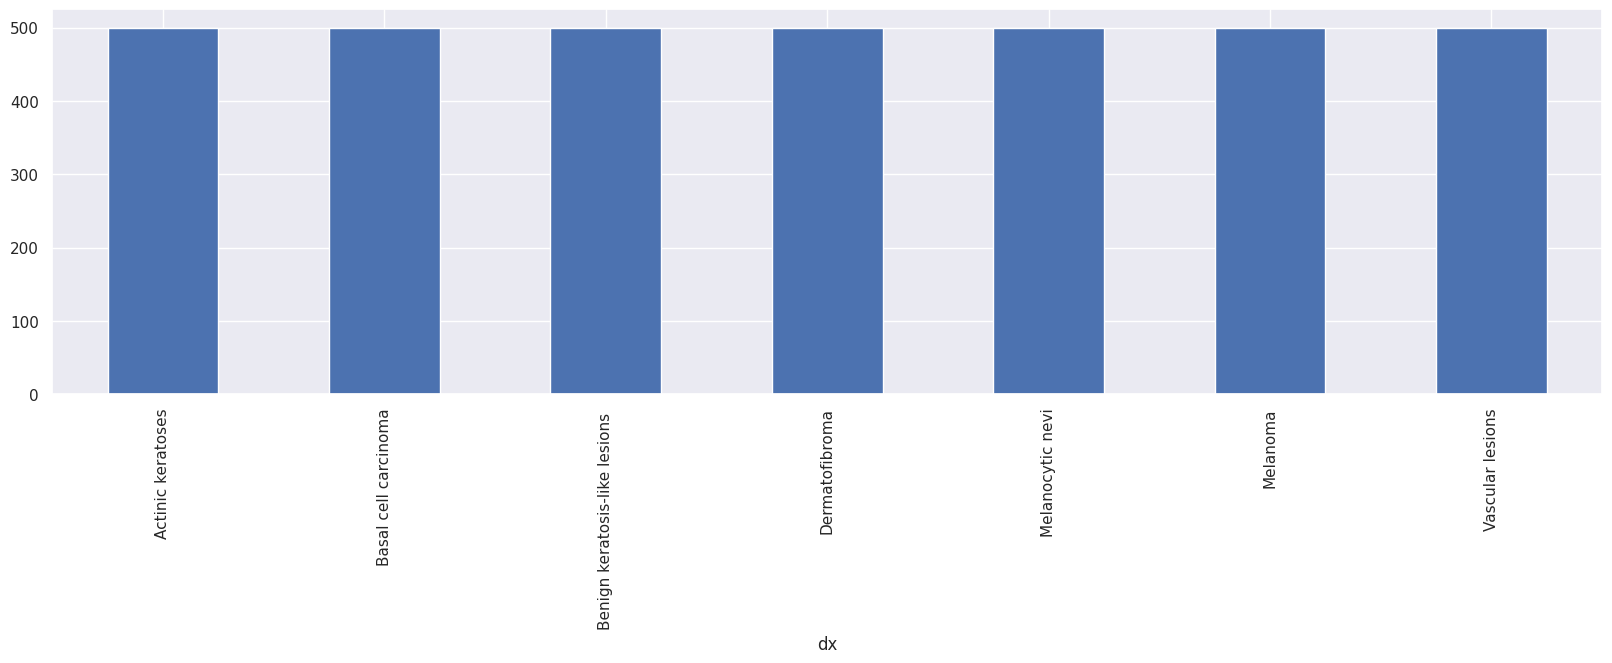

In [31]:
folder_label = [x for x in df.dx.unique()]
y = x.groupby('dx')['label'].count()
y.plot(kind='bar')

# EDA - 2. Visual EDA

Working with image data can be overwhelming, to have to view through so many images can be tedious. I highly recommend checking out Voxel fiftyone [here](https://docs.voxel51.com/) to find out about quick image discovery.

Here is some boiler plate colde to randomly sample images. 

In [3]:
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt

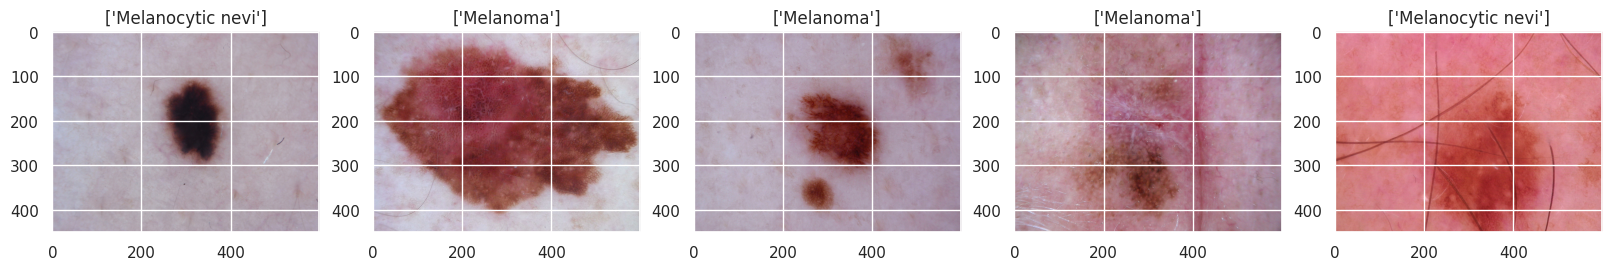

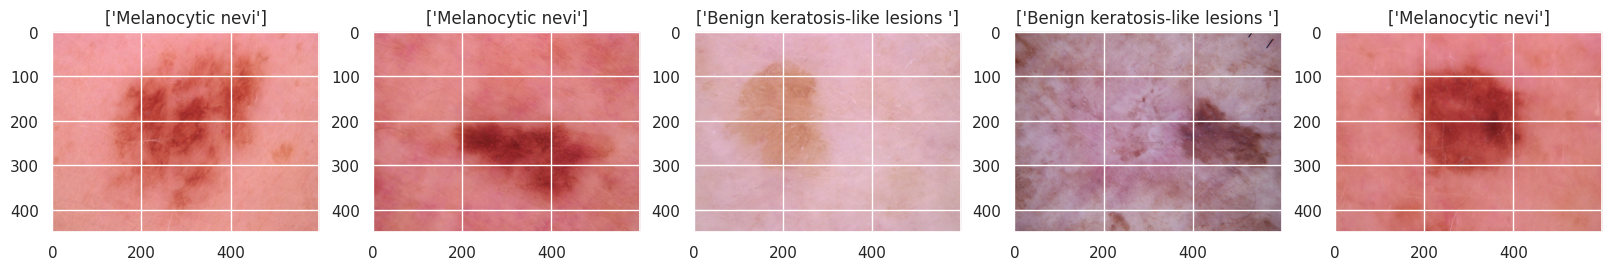

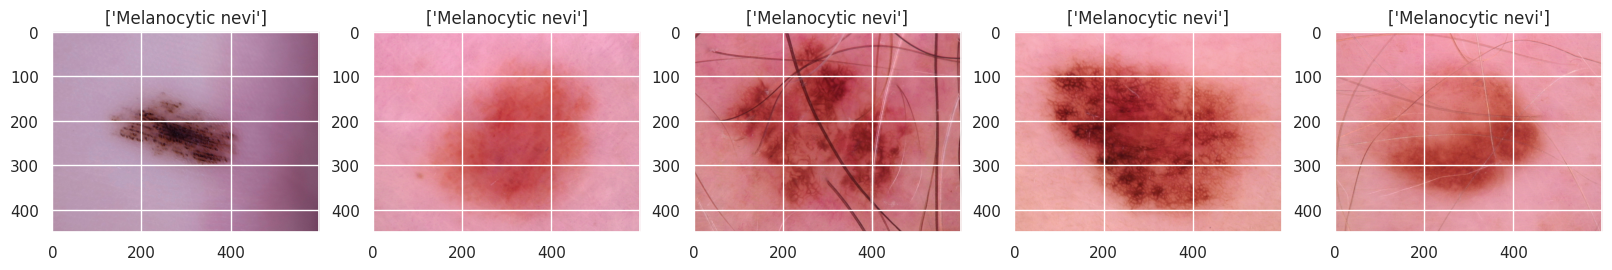

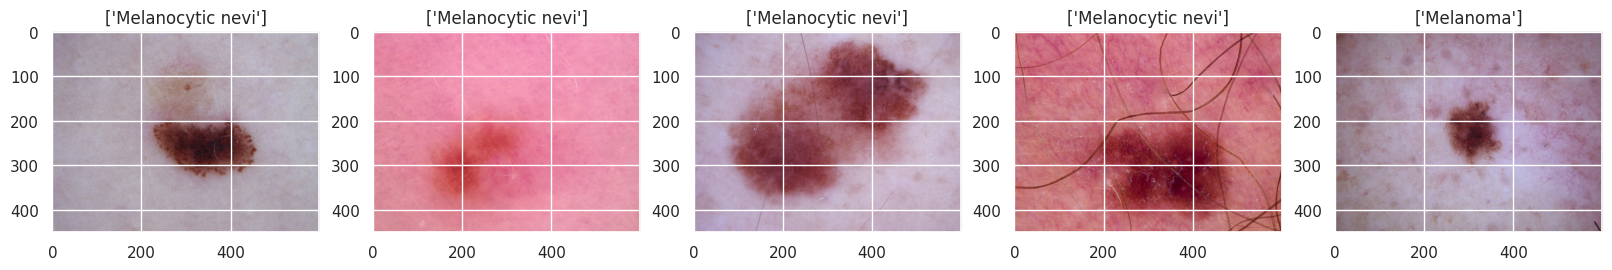

In [19]:
# Depending on your directory structure you can do it by folder or by 
plt.figure(figsize=(20,20))

def show_n_images(img_folder, num=5):
    for i in range(int(num)):
        file = random.choice(os.listdir(img_folder))
        image_path= os.path.join(img_folder, file)
        img=cv2.imread(image_path, cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax=plt.subplot(1,5,i+1)
        name = df.loc[df['filepath']==image_path,'dx'].tolist()
        ax.title.set_text(name)
        plt.imshow(img)
    plt.show()

folder = '../data'

for root, dirs, files in os.walk(folder): 
    for d in dirs:
        dir_path = os.path.join(root, d)
        show_n_images(dir_path, 5)


In [ ]:
# If there is a need to view the dataset after being converted to tensor you can use the code below.
# Just remember to add back the mean and std dev, as the normalization process is to subtract the mean and divide by std dev

# plt.figure(figsize=(20,20))

# # viewing test dataset
# # show the first image of the first 5 batches
# for i in range(0, 5):
#     batch = next(iter(train_loader))
#     img, label = batch['image'], batch['label']
#     ax=plt.subplot(1,5,i+1)
#     ax.title.set_text(label[1])
#     # de-normalized tensor image from original
#     np_img = img[1].numpy().transpose((1, 2, 0))
#     np_img = std * np_img + mean
#     np_img = np.clip(np_img, 0, 1)
#     plt.imshow(np_img)
# plt.show()